# \[pyod\] tutorial

김보람  
2023-10-04

# KNN

## import

In [53]:
from pyod.models.knn import KNN   # kNN detector
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize


## data

In [6]:
contamination = 0.1  # 이상치 비율
n_train = 200  # number of training points
n_test = 100  # number of testing points

X_train, X_test, y_train, y_test = generate_data(n_train=n_train, n_test=n_test, contamination=contamination)

## KNN()

In [9]:
# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

In [10]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: 정상, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

`y_train_scores`: 이상치 점수??

In [40]:
y_train_scores[:-20].min(),y_train_scores[:-20].max()

In [41]:
y_train_scores[20:].min(),y_train_scores[20:].max()

In [42]:
y_train_scores.mean()

In [43]:
# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

In [45]:
y_test_scores

In [46]:

# it is possible to get the prediction confidence as well
y_test_pred, y_test_pred_confidence = clf.predict(X_test, return_confidence=True)  # outlier labels (0 or 1) and confidence in the range of [0,1]

In [48]:
y_test_pred_confidence

In [50]:

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:1.0, precision @ rank n:1.0

On Test Data:
KNN ROC:1.0, precision @ rank n:1.0

-   ROC값이 1인 경우 모델이 이상치 제대로 식별했음

-   rank n:1.0은 100% precision 값

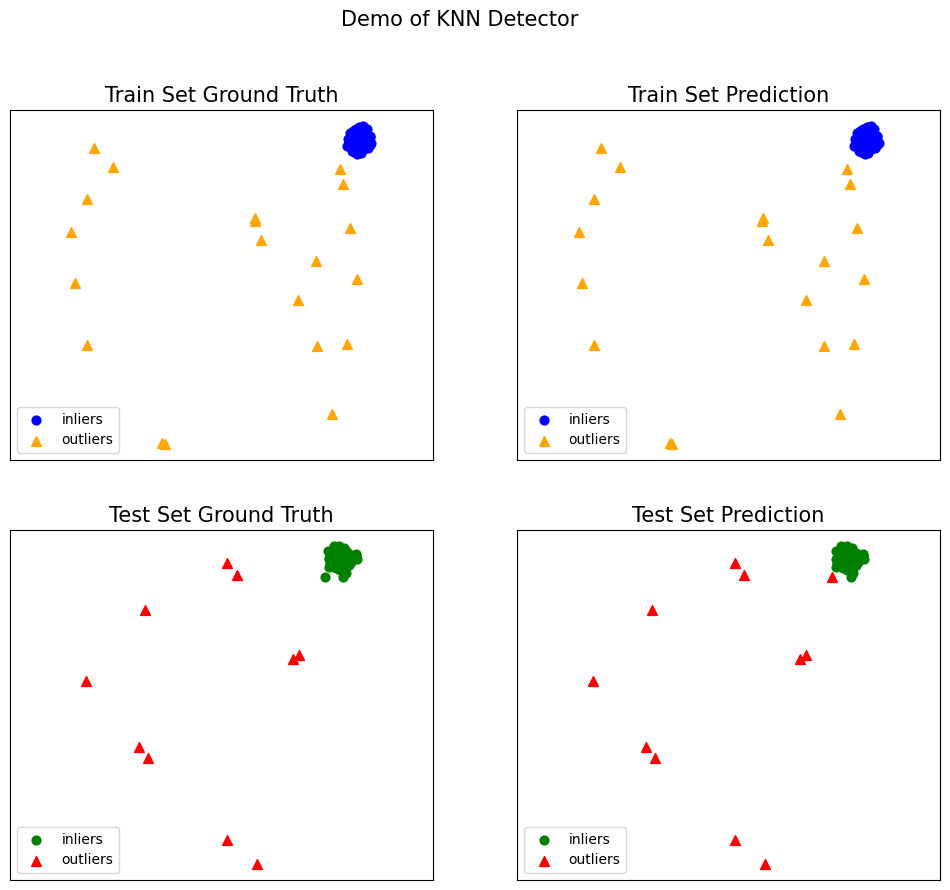

In [54]:
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

# Model Combination Example

## import

In [57]:
# pip install combo

In [73]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.knn import KNN
from pyod.models.combination import aom, moa, average, maximization, median
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

## data

In [59]:
X, y= generate_data(train_only=True)  # load data

In [63]:
X.shape, y.shape

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [75]:
 X_train_norm, X_test_norm = standardizer(X_train, X_test)

In [76]:
# initialize 20 base detectors for combination
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140,
            150, 160, 170, 180, 190, 200]
n_clf = len(k_list) # Number of classifiers being trained

In [77]:
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

In [78]:
X_train.shape[0], X_test.shape[0]

In [79]:
for i in range(n_clf):
    k = k_list[i]

    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm)

In [81]:
 # Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

In [86]:
# Combination by average
y_by_average = average(test_scores_norm)
evaluate_print('Combination by Average', y_test, y_by_average)

# Combination by max
y_by_maximization = maximization(test_scores_norm)
evaluate_print('Combination by Maximization', y_test, y_by_maximization)

# Combination by median
y_by_median = median(test_scores_norm)
evaluate_print('Combination by Median', y_test, y_by_median)

# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=5)
evaluate_print('Combination by AOM', y_test, y_by_aom)

# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=5)
evaluate_print('Combination by MOA', y_test, y_by_moa)

Combination by Average ROC:1.0, precision @ rank n:1.0
Combination by Maximization ROC:1.0, precision @ rank n:1.0
Combination by Median ROC:1.0, precision @ rank n:1.0
Combination by AOM ROC:1.0, precision @ rank n:1.0
Combination by MOA ROC:1.0, precision @ rank n:1.0

# threshold_exmple

## import

In [87]:
from pyod.models.kde import KDE
from pyod.models.thresholds import FILTER
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

## data

In [88]:
contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

 # Generate sample data
X_train, X_test, y_train, y_test = \
generate_data(n_train=n_train,
              n_test=n_test,
              n_features=2,
              contamination=contamination,
              random_state=42)


In [93]:
# train KDE detector
clf_name = 'KDE'
clf = KDE(contamination=FILTER())
clf.fit(X_train)

In [96]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores


In [97]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)



On Training Data:
KDE ROC:0.9992, precision @ rank n:0.95

On Test Data:
KDE ROC:1.0, precision @ rank n:1.0

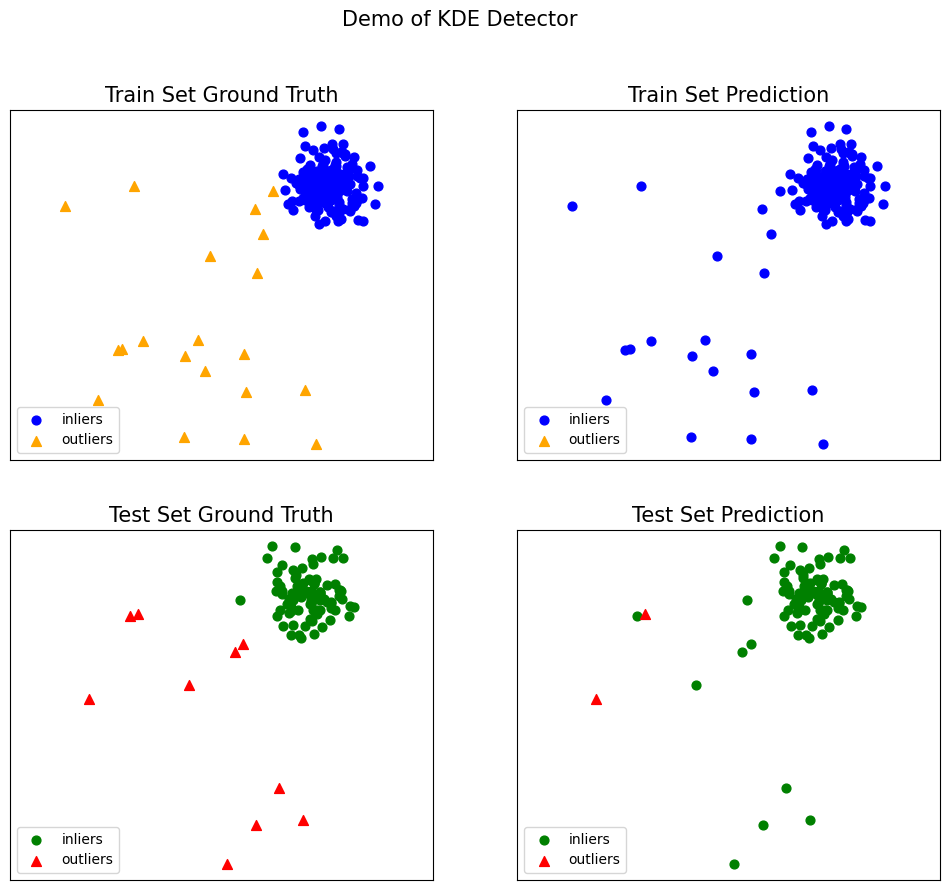

In [98]:
# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)